In [ ]:
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt

# 텍스트 데이터 분석
- 네이버 영화 리뷰 데이터 다운로드
- 텍스트 정제(cleaning) 및 정규화 (normalization)
- padding, oov로 판단할 단어 빈도 분석하기

## 데이터 다운로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f08a20510a0>)

## 데이터 프레임 생성


In [ ]:
df_train = pd.read_table('ratings_train.txt')
df_test = pd.read_table('ratings_test.txt')

In [ ]:
df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
df_test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## 중복 데이터확인 및 처리

In [ ]:
df_train['document'].nunique()
# 대충 4천개 정도 리뷰가 중복되어있다!

146182

In [ ]:
# 중복 데이터 제거
df_train = df_train.drop_duplicates(subset = ['document'])
df_train.nunique()

id          146183
document    146182
label            2
dtype: int64

## 레이블에 대한 비율 확인
- 긍정, 부정 리뷰 비율 확인
- 치우치지 않게 훈련하기 위해서

In [ ]:
df_train['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

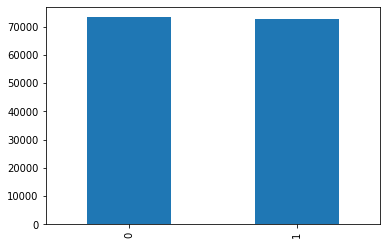

In [ ]:
df_train['label'].value_counts().plot(kind='bar')
plt.show()

## Nan값 확인 및 제거

In [ ]:
df_train['document'].isnull().sum()

1

In [ ]:
df_train.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
df_train = df_train.dropna(how='any')
df_train.isnull().sum()

id          0
document    0
label       0
dtype: int64

## 정규식을 통한 텍스트 정제
- 특수문자, 영어를 모두 제거하고 한글 데이터만 남길 예정
- ㅋㅋㅋㅋ ㅜㅜㅜㅜ 같은 자음이나 모음만 있는 한글도 남길 예정

In [ ]:
# series.str의 replace는 정규식도 지원
df_train['document'] = df_train['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]', '').str.strip() # ^ = not
df_train.head()

<ipython-input-23-bfdc9761561e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['document'] = df_train['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]', '').str.strip() # ^ = not


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# 영어로만 이루어진 리뷰같은건 내용이 사라졌을거임
# ''인 리뷰몇개일까?
df_train.loc[df_train['document'] == '', 'document'].value_counts()

    789
Name: document, dtype: int64

영어, 특수문자로만 이루어진 리뷰는 모든 문자열이 사라져따..

In [ ]:
df_train['document'].replace('', np.nan, inplace=True) # 비어있는칸 nan값으로 치환하기
df_train = df_train.dropna(how='any') # nan값 제거하기!
df_train.loc[df_train['document'] == '', 'document'].value_counts()

Series([], Name: document, dtype: int64)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145393 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [ ]:
# 맞춤법검사, 띄어쓰기 교정등을 수정하면 더 좋을듯

In [ ]:
# 테스트 데이터도 훈련 데이터와 동일하게 처리
df_test.drop_duplicates(subset=['document'], inplace=True) # inplace 원본을 바꿔줌! 안하면 따로또저장해야함
df_test['document'] = df_test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "").str.strip()
df_test['document'].replace('', np.nan, inplace=True)
df_test = df_test.dropna(how='any')

<ipython-input-29-5c94812d8476>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['document'] = df_test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "").str.strip()


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48852 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


## 형태소 분리 및 정규화(stem, norm)

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 465 kB 53.2 MB/s 


In [ ]:
from tqdm import tqdm_notebook
from konlpy.tag import Okt

okt = Okt()

In [ ]:
# 단어 토큰 리스트를 추가할 리스트
X_train = [] # [[단어1, 단어2], [단어1, 단어2, 단어3],...]
# '문장 별' 단어 토큰 리스트를 가지고있을 리스트

for sentence in tqdm_notebook(df_train['document']):
  temp_X = okt.morphs(sentence, stem=True, norm=True)
  X_train.append(temp_X)


<ipython-input-33-1819fefaf4f4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(df_train['document']):


  0%|          | 0/145393 [00:00<?, ?it/s]

In [ ]:
# 컴프리헨션으로 한다묜
# X_test = [ okt.morphs(sentence, stem=True, norm=True) for sentence in tqdm_notebook(df_test['document']) ]

In [ ]:
# 오래걸려서 강사님이 한거 다운받깅
import pickle

with open("./X_test.pickle", 'rb') as f:
  X_test = pickle.load(f)

In [ ]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다']]

In [ ]:
X_test[:3]

[['굳다', 'ㅋ'],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘다',
  '않다',
  '점',
  '짜다',
  '리',
  '는',
  '더',
  '더욱',
  '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

## 토크나이저 생성

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 단어 집합 확인
print(tokenizer.word_index)

{'이': 1, '영화': 2, '보다': 3, '하다': 4, '의': 5, '에': 6, '가': 7, '을': 8, '도': 9, '은': 10, '들': 11, '는': 12, '를': 13, '없다': 14, '이다': 15, '있다': 16, '좋다': 17, '너무': 18, '재밌다': 19, '다': 20, '정말': 21, '한': 22, '것': 23, '되다': 24, '적': 25, '만': 26, '같다': 27, '진짜': 28, '으로': 29, '아니다': 30, '않다': 31, '로': 32, '점': 33, '에서': 34, '만들다': 35, '과': 36, '나오다': 37, '연기': 38, '평점': 39, '내': 40, '최고': 41, '그': 42, '나': 43, '안': 44, '인': 45, '왜': 46, '스토리': 47, '생각': 48, '못': 49, '드라마': 50, '감동': 51, '사람': 52, '게': 53, '보고': 54, 'ㅋㅋㅋ': 55, '말': 56, '이렇다': 57, '아깝다': 58, '고': 59, '더': 60, '배우': 61, '때': 62, 'ㅋㅋ': 63, '와': 64, '아': 65, '감독': 66, '거': 67, '그냥': 68, '재미있다': 69, '뭐': 70, '시간': 71, '재미': 72, '내용': 73, '요': 74, '까지': 75, '주다': 76, '중': 77, '좀': 78, '자다': 79, '하고': 80, '지루하다': 81, '재미없다': 82, '쓰레기': 83, '수': 84, '네': 85, '가다': 86, '모르다': 87, '들다': 88, '그렇다': 89, '싶다': 90, '작품': 91, '알다': 92, '사랑': 93, '하나': 94, '다시': 95, '마지막': 96, '볼': 97, '잘': 98, '지': 99, '정도': 100, '저': 101, '처음': 102, '이렇게': 10

## 희귀 단어 빈도수 확인
- 빈도수가 적은 단어는 사용하지 않을 계획
- 오타, 신조어 등 일반적으로 사용하지 않는 단어는 제거하는 것이 좋다.

In [ ]:
# threshold 만큼 등장하지 않은 단어들의 비율 확인
def print_freq(threshold):

  total_cnt = len(tokenizer.word_index) # 전체 단어 개수
  rare_cnt  = 0 # 등장 빈도가 threshold보다 작은 단어의 개수를 카운트

  total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합. 영화: 3번, 재미: 5번 -> total_freq = 8
  rare_freq  = 0 # 사용된 희귀 단어의 총 합

  for key, value in tokenizer.word_counts.items():
    # key : 단어, value : 빈도수
    total_freq = total_freq + value # 모든 단어의 빈도수 총 합 구하기

    # 희귀단어 개수 및 등장 빈도 계산하기
    if value < threshold :
      rare_cnt += 1
      rare_freq += value

  print("단어 집합의 크기 : {}".format(total_cnt))
  print("등장 빈도가 {} 미만인 희귀 단어의 수 : {}".format(threshold, rare_cnt))
  print("단어 집합에서 희귀 단어의 비율 : {:.3f}%".format((rare_cnt / total_cnt) * 100))
  print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : {:.3f}%".format((rare_freq / total_freq) * 100))
  print("="*50)
  
  return total_cnt, rare_cnt

In [ ]:
tokenizer.word_counts.items()
# word_counts 단어 등장 횟수

odict_items([('아', 4151), ('더빙', 573), ('진짜', 8324), ('짜증나다', 1092), ('목소리', 375), ('흠', 252), ('포스터', 573), ('보고', 4656), ('초딩', 421), ('영화', 50443), ('줄', 1236), ('오버', 142), ('연기', 6326), ('조차', 242), ('가볍다', 361), ('않다', 7725), ('너', 606), ('무재', 3), ('밓었', 1), ('다그', 74), ('래서', 20), ('보다', 41124), ('추천', 1183), ('한', 9632), ('다', 9969), ('교도소', 16), ('이야기', 2174), ('구먼', 10), ('솔직하다', 1203), ('재미', 3859), ('는', 16917), ('없다', 15583), ('평점', 6266), ('조정', 40), ('사이', 222), ('몬페', 2), ('그', 5643), ('의', 30823), ('익살스럽다', 9), ('가', 26574), ('돋보이다', 288), ('스파이더맨', 64), ('에서', 6981), ('늙다', 198), ('보이다', 1071), ('하다', 40876), ('커스틴', 4), ('던스트', 2), ('너무나도', 206), ('이쁘다', 1034), ('막', 333), ('걸음', 20), ('마', 235), ('떼다', 151), ('세', 600), ('부터', 1788), ('초등학교', 116), ('학년', 121), ('생인', 6), ('살다', 1176), ('ㅋㅋㅋ', 4632), ('별', 1906), ('반개', 205), ('도', 21067), ('아깝다', 4425), ('움', 1053), ('원작', 1253), ('긴장감', 832), ('을', 23230), ('제대로', 796), ('살리다', 535), ('욕', 782), ('나오다', 6403), ('

In [ ]:
print_freq(2)
print_freq(3)
print_freq(4)
print_freq(5)

단어 집합의 크기 : 42962
등장 빈도가 2 미만인 희귀 단어의 수 : 18193
단어 집합에서 희귀 단어의 비율 : 42.347%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.953%
단어 집합의 크기 : 42962
등장 빈도가 3 미만인 희귀 단어의 수 : 23704
단어 집합에서 희귀 단어의 비율 : 55.174%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.531%
단어 집합의 크기 : 42962
등장 빈도가 4 미만인 희귀 단어의 수 : 26830
단어 집합에서 희귀 단어의 비율 : 62.451%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.022%
단어 집합의 크기 : 42962
등장 빈도가 5 미만인 희귀 단어의 수 : 28823
단어 집합에서 희귀 단어의 비율 : 67.090%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.440%


(42962, 28823)

# 우리는 등장빈도 3미만인것들 버려보자

## 토크나이저 새롭게 만들기
- 희귀단어 제거(3회 미만 등장), oov, padding고려해서 토크나이저 만들기

In [ ]:
total_cnt, rare_cnt = print_freq(3)

단어 집합의 크기 : 42962
등장 빈도가 3 미만인 희귀 단어의 수 : 23704
단어 집합에서 희귀 단어의 비율 : 55.174%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.531%


In [ ]:
# 전체 단어 개수
total_cnt

42962

In [ ]:
# 희귀 단어 개수
rare_cnt

23704

In [ ]:
vocab_size = total_cnt - rare_cnt + 2 # oov, padding을 위해
print(vocab_size)

19260


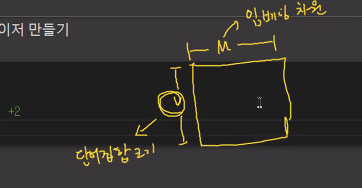

In [ ]:
# 희귀 단어가 포함되지 않은(oov 처리가 될) 토크나이저 만들기
tokenizer = Tokenizer(vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

## 정수인코딩
- 텍스트들을 숫자로 바꿔주기

In [ ]:
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_train_encoded[:3]

[[66, 469, 29, 255, 676],
 [940, 470, 55, 622, 3, 230, 1464, 39, 971, 693, 32],
 [439, 16134, 1, 2326, 5642, 4, 240, 23, 21]]

In [ ]:
X_train_encoded[400]

[79, 9755, 25, 188, 12, 79, 3225, 297, 3387, 2736, 436, 5]

# Feature, Label 확인

In [ ]:
y_train = np.array(df_train['label'])

In [ ]:
np.shape(X_train_encoded), y_train.shape

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


((145393,), (145393,))

## 패딩 설정
- 모든 문장의 길이를 맞춰주기 위해 패딩을 수행

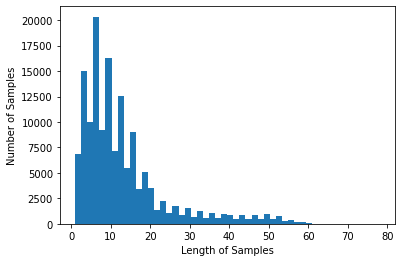

In [ ]:
# 시각화
plt.hist([len(s) for s in X_train], bins=50) # bins 가로축 구간의 개수
plt.xlabel("Length of Samples")
plt.ylabel("Number of Samples")
plt.show()

In [ ]:
print("리뷰의 최대 길이 : {}".format(max(len(l) for l in X_train_encoded)))
print("리뷰의 평균 길이 : {}".format(sum(map(len, X_train_encoded)) / len(X_train_encoded)))

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 13.12573507665431


In [ ]:
def below_threshold_len(max_len, nested_list):

  cnt = 0
  for s in nested_list:
    if len(s) <= max_len:
      cnt = cnt + 1

  print("전체 샘플 중 길이가 {} 이하인 샘플의 비율 : {}".format(max_len, (cnt / len(nested_list) * 100)))

In [ ]:
below_threshold_len(20, X_train_encoded)
below_threshold_len(30, X_train_encoded)
below_threshold_len(40, X_train_encoded)
below_threshold_len(50, X_train_encoded)

전체 샘플 중 길이가 20 이하인 샘플의 비율 : 84.23720536752113
전체 샘플 중 길이가 30 이하인 샘플의 비율 : 91.38954420089
전체 샘플 중 길이가 40 이하인 샘플의 비율 : 95.2274181012841
전체 샘플 중 길이가 50 이하인 샘플의 비율 : 98.39607133768476


In [ ]:
# 30개 선택해야징 9%정도데이터는 짤리게 될겨
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_encoded, maxlen=30)
X_train_padded[:2]
# 앞쪽에채워졌으니 prepadding

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   66,  469,   29,  255,  676],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  940,  470,   55,
         622,    3,  230, 1464,   39,  971,  693,   32]], dtype=int32)

In [ ]:
# 혹시 안되면 강사님꺼 불러오기
# import pickle

# with open("./X_train_padded.pkl", 'rb') as f:
#   X_train_padded = pickle.load(f)

# with open("./t_train.pkl", 'rb') as f:
#   y_train = pickle.load(f)

# LSTM 모델 생성하기


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential([
    Embedding(vocab_size, 128), # (단어개수, embedding dim차원)
    # lookupTable은 지가 알아서 다 만들어줌 상관안해도됨!
    LSTM(128),

    # 평탄화가 되어있기 때문에 바로 FCL로 연결
    Dense(32, activation='tanh'),

    # 출력층
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2465280   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,601,025
Trainable params: 2,601,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
y_train[:3]

array([0, 1, 0])

In [ ]:
# 훈련
model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/5
1818/1818 [==============================] - 14s 8ms/step - loss: 0.1512 - acc: 0.9406 - val_loss: 0.4434 - val_acc: 0.8440
Epoch 2/5
1818/1818 [==============================] - 13s 7ms/step - loss: 0.1208 - acc: 0.9540 - val_loss: 0.4978 - val_acc: 0.8438
Epoch 3/5
1818/1818 [==============================] - 15s 8ms/step - loss: 0.0956 - acc: 0.9637 - val_loss: 0.5974 - val_acc: 0.8396
Epoch 4/5
1818/1818 [==============================] - 13s 7ms/step - loss: 0.0779 - acc: 0.9708 - val_loss: 0.6378 - val_acc: 0.8399
Epoch 5/5
1818/1818 [==============================] - 13s 7ms/step - loss: 0.0656 - acc: 0.9757 - val_loss: 0.6812 - val_acc: 0.8372


In [ ]:
# 평가
X_test[:3]

[['굳다', 'ㅋ'],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘다',
  '않다',
  '점',
  '짜다',
  '리',
  '는',
  '더',
  '더욱',
  '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

# Test셋도 전처리 해줘야한다.
- 훈련세트에서 사용한 토크나이저를 그대로 활용

In [ ]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)     # 정수인코딩
X_test_padded = pad_sequences(X_test_encoded, maxlen=30)  # 패딩 다해주기
y_test = df_test['label']

X_test_padded.shape, y_test.shape

((48852, 30), (48852,))

In [ ]:
model.evaluate(X_test_padded, y_test)

1527/1527 [==============================] - 7s 4ms/step - loss: 0.7067 - acc: 0.8326


[0.7067456245422363, 0.8326168656349182]

In [ ]:
# 일반 자연어(새로운 문장)가 들어 왔을 때 모델을 이용한 처리
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  
  # 정수 인코딩
  encoded = tokenizer.texts_to_sequences([new_sentence])
  
  # 패딩
  pad_new = pad_sequences(encoded, maxlen=30)

  # 예측
  score = float(model.predict(pad_new))

  # 시그모이드를 사용했기 때문에 결과값이 0.5 넘어가면 긍정 리뷰(1)
  if score > 0.5 :
    print("{:.2f}% 확률로 긍정 리뷰 입니다.".format(score * 100))
  else:
    # 0.5 미만이면 부정 리뷰 (0)
    print("{:.2f}% 확률로 부정 리뷰 입니다.".format(( 1 - score ) * 100))

In [ ]:
sentiment_predict("오늘 수업 재미있었다")

1/1 [==============================] - 1s 531ms/step
79.37% 확률로 긍정 리뷰 입니다.


In [ ]:
sentiment_predict("오늘 수업 진짜 개노잼ㅋㅋㅋㅋㅋ")

1/1 [==============================] - 0s 17ms/step
97.93% 확률로 부정 리뷰 입니다.


In [ ]:
sentiment_predict("뒷자리에서 발로 찼지만 잠을 잘 잘 수 있었어요")

1/1 [==============================] - 0s 17ms/step
99.96% 확률로 부정 리뷰 입니다.


In [ ]:
sentiment_predict("개좋아")

1/1 [==============================] - 0s 17ms/step
96.01% 확률로 긍정 리뷰 입니다.


In [ ]:
sentiment_predict("배우들의 연기는 괜찮았지만 스토리는 영 재미가 없었어요")

1/1 [==============================] - 0s 17ms/step
99.88% 확률로 부정 리뷰 입니다.


In [ ]:
sentiment_predict("잘잤다")

1/1 [==============================] - 0s 15ms/step
65.82% 확률로 부정 리뷰 입니다.


In [ ]:
sentiment_predict("나만 당할순 없지")

1/1 [==============================] - 0s 17ms/step
84.47% 확률로 긍정 리뷰 입니다.


In [ ]:
sentiment_predict("불면증을 해결해준 좋은 영화")

1/1 [==============================] - 0s 18ms/step
98.92% 확률로 부정 리뷰 입니다.


In [ ]:
# 모델 저장
model.save("./my_naver_model.h5")

In [ ]:
# 저장된 모델 불러오기
import tensorflow as tf
model2 = tf.keras.models.load_model("./my_naver_model.h5")
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2465280   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,601,025
Trainable params: 2,601,025
Non-trainable params: 0
_________________________________________________________________
